In [2]:
import pandas as pd
import random

# Load your Excel file
df = pd.read_csv('Project_Dataset.csv')  # Replace with your actual file name

# Function to convert date format
def convert_date(date_str):
    year = date_str[:4]
    month = date_str[5:7]
    day = random.randint(1, 28)  # Random day between 1 and 28
    return f"{day:02d}/{month}/{year}"

# Apply the function to your date column (replace 'DateColumn' with your actual column name)
df['Date'] = df['Date'].apply(convert_date)

# Save the modified DataFrame to a CSV file
df.to_csv('converted_dates.csv', index=False)

print("File saved as converted_dates.csv")


File saved as converted_dates.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# -------------------------------
# 1. Load the Dataset
# -------------------------------
df = pd.read_csv("converted_dates.csv")

# -------------------------------
# 2. Convert Date Column to Datetime
# -------------------------------
# Our dates are in DD/MM/YYYY format.
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# -------------------------------
# 3. Basic Overview
# -------------------------------
print("Initial Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:")
print(df.head())

# -------------------------------
# 4. Missing Values & Duplicates
# -------------------------------
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Remove any missing rows
df.dropna(inplace=True)
print("After dropping missing values, shape:", df.shape)

# Remove duplicate rows if any
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Removed duplicate rows. New shape:", df.shape)
else:
    print("No duplicate rows found.")

# -------------------------------
# 5. Outlier Removal Using IQR Method
# -------------------------------
# List of numerical columns (all except 'Date' and the categorical 'District')
numeric_columns = [
    "Population", "Growth Rate (%)", "Rainfall (mm)", "Inflow (MLD)",
    "Outflow (MLD)", "Domestic (MLD)", "Industrial (MLD)", "Agricultural (MLD)"
]

def remove_outliers(dataframe, col):
    Q1 = dataframe[col].quantile(0.25)
    Q3 = dataframe[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]

# Remove outliers for each numeric column
for col in numeric_columns:
    before_rows = df.shape[0]
    df = remove_outliers(df, col)
    after_rows = df.shape[0]
    print(f"Column '{col}': Removed {before_rows - after_rows} outlier rows.")

# -------------------------------
# 6. Consistency Checks
# -------------------------------
# Ensure Inflow is always greater than or equal to Outflow
inconsistent = df[df["Inflow (MLD)"] < df["Outflow (MLD)"]]
if not inconsistent.empty:
    df = df[df["Inflow (MLD)"] >= df["Outflow (MLD)"]]
    print("Removed rows where Inflow < Outflow.")
else:
    print("No inconsistency found for Inflow and Outflow.")

# Check for negative values in numeric columns
for col in numeric_columns:
    if (df[col] < 0).any():
        df = df[df[col] >= 0]
        print(f"Removed rows with negative values in '{col}'.")

# -------------------------------
# 7. Convert Categorical Data to Numerical
# -------------------------------
# Convert the 'District' column to numerical via one-hot encoding.
# Using drop_first=True to avoid multicollinearity if needed.
df = pd.get_dummies(df, columns=["District"], drop_first=True)
print("Converted categorical column 'District' to numerical. New shape:", df.shape)

# -------------------------------
# 8. Reset Index
# -------------------------------
df.reset_index(drop=True, inplace=True)

# -------------------------------
# 9. Overwrite the Original File with the Pre-Processed Dataset
# -------------------------------
# df.to_csv(file_path, index=False)
# print("\nPre-processing complete. The original dataset has been updated at:")
# print(file_path)

# -------------------------------
# 10. Final Overview
# -------------------------------
print("\nFinal Dataset Shape:", df.shape)
print("\nSummary Statistics:")
print(df.describe())

Initial Dataset Shape: (5000, 11)
Columns: ['District', 'Year', 'Population', 'Growth Rate (%)', 'Date', 'Rainfall (mm)', 'Inflow (MLD)', 'Outflow (MLD)', 'Domestic (MLD)', 'Industrial (MLD)', 'Agricultural (MLD)']
First few rows:
    District  Year  Population  Growth Rate (%)       Date  Rainfall (mm)  \
0  Ratnagiri  2021      911070             1.23 2021-06-13         712.51   
1   Kolhapur  2021     3695760             2.66 2021-09-18         302.14   
2  Nandurbar  2024     3001136             2.23 2024-07-07         791.39   
3  Nandurbar  2024     3001136             2.23 2024-02-09          10.04   
4    Solapur  2024     4439388             1.16 2024-09-13         334.72   

   Inflow (MLD)  Outflow (MLD)  Domestic (MLD)  Industrial (MLD)  \
0       1566.75        1128.08          362.19            339.73   
1       1080.91         850.93          413.99            205.76   
2       1678.80        1483.15          525.84            436.82   
3        323.86         258.01    

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# -------------------------------
# 1. Load the Pre-Processed Dataset
# -------------------------------
# (This is the same file you created earlier; we will update it in place.)

# file_path = '/mnt/data/Water_Resource_Demand_Forecasting_Dataset.csv'
# df = pd.read_csv(file_path)

# Ensure the Date column is in datetime format (it was stored as DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# -------------------------------
# 2. Define Features & Target for Forecasting
# -------------------------------
# Our goal is to forecast Outflow (MLD) based on other available features.
# We remove the following from our features:
#   - 'Date' (we don’t use it directly in these models)
#   - The target column itself: 'Outflow (MLD)'
#   - The columns 'Domestic (MLD)', 'Industrial (MLD)', 'Agricultural (MLD)'
#     (which are derivable from Outflow and not used as predictors here)
target = 'Outflow (MLD)'
drop_cols = ['Date', target, 'Domestic (MLD)', 'Industrial (MLD)', 'Agricultural (MLD)']

# The remaining columns (including one-hot encoded District columns) are our predictors.
features = [col for col in df.columns if col not in drop_cols]
X = df[features]
y = df[target]

print("Feature columns used for modeling:")
print(X.columns.tolist())

# -------------------------------
# 3. Split the Dataset into Training (80%) & Testing (20%)
# -------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("\nTrain/Test split:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

# -------------------------------
# 4. Scale the Features
# -------------------------------
# For many ML models (especially those based on gradient descent or NN),
# scaling the features is important.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 5. Define Functions to Compute Metrics
# -------------------------------
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, precision_score, recall_score, accuracy_score
)

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def classification_metrics(y_true, y_pred, threshold):
    """
    For demonstration only: binarize continuous targets based on a threshold
    (here, the median) to compute F1, Precision, Recall, and Accuracy.
    """
    y_true_bin = (y_true >= threshold).astype(int)
    y_pred_bin = (y_pred >= threshold).astype(int)
    f1 = f1_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin)
    recall = recall_score(y_true_bin, y_pred_bin)
    accuracy = accuracy_score(y_true_bin, y_pred_bin)
    return f1, precision, recall, accuracy

# Choose a threshold for binarization (using the median of the training target)
threshold = np.median(y_train)

# -------------------------------
# 6. XGBoost Model
# -------------------------------
print("\n--- XGBoost Model ---")
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Regression Metrics:
mae_xgb, mse_xgb, rmse_xgb, r2_xgb = regression_metrics(y_test, y_pred_xgb)
# Classification Metrics (after binarization)
f1_xgb, prec_xgb, recall_xgb, acc_xgb = classification_metrics(y_test, y_pred_xgb, threshold)

print("XGBoost Regression Metrics:")
print(f"  MAE:  {mae_xgb:.3f}")
print(f"  MSE:  {mse_xgb:.3f}")
print(f"  RMSE: {rmse_xgb:.3f}")
print(f"  R2:   {r2_xgb:.3f}")

print("XGBoost Classification Metrics (after binarizing):")
print(f"  F1 Score:  {f1_xgb:.3f}")
print(f"  Precision: {prec_xgb:.3f}")
print(f"  Recall:    {recall_xgb:.3f}")
print(f"  Accuracy:  {acc_xgb*100:.3f}")

# -------------------------------
# 7. Linear Regression Model (Baseline)
# -------------------------------
print("\n--- Linear Regression Model ---")
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

mae_lr, mse_lr, rmse_lr, r2_lr = regression_metrics(y_test, y_pred_lr)
f1_lr, prec_lr, recall_lr, acc_lr = classification_metrics(y_test, y_pred_lr, threshold)

print("Linear Regression Metrics:")
print(f"  MAE:  {mae_lr:.3f}")
print(f"  MSE:  {mse_lr:.3f}")
print(f"  RMSE: {rmse_lr:.3f}")
print(f"  R2:   {r2_lr:.3f}")

print("Linear Regression Classification Metrics (after binarizing):")
print(f"  F1 Score:  {f1_lr:.3f}")
print(f"  Precision: {prec_lr:.3f}")
print(f"  Recall:    {recall_lr:.3f}")
print(f"  Accuracy:  {acc_lr*100:.3f}")

# -------------------------------
# 8. LSTM Model
# -------------------------------
print("\n--- LSTM Model ---")
# LSTM models require a 3D input: (samples, timesteps, features).
# Here, we use a window (timestep) of 1 for each independent sample.
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Build a simple LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Use EarlyStopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the LSTM
history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# Predict on test data
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

mae_lstm, mse_lstm, rmse_lstm, r2_lstm = regression_metrics(y_test, y_pred_lstm)
f1_lstm, prec_lstm, recall_lstm, acc_lstm = classification_metrics(y_test, y_pred_lstm, threshold)

print("LSTM Regression Metrics:")
print(f"  MAE:  {mae_lstm:.3f}")
print(f"  MSE:  {mse_lstm:.3f}")
print(f"  RMSE: {rmse_lstm:.3f}")
print(f"  R2:   {r2_lstm:.3f}")

print("LSTM Classification Metrics (after binarizing):")
print(f"  F1 Score:  {f1_lstm:.3f}")
print(f"  Precision: {prec_lstm:.3f}")
print(f"  Recall:    {recall_lstm:.3f}")
print(f"  Accuracy:  {acc_lstm*100:.3f}")

# -------------------------------
# 9. ARIMA Model (Time Series Forecasting)
# -------------------------------
print("\n--- ARIMA Model ---")
# ARIMA is designed for univariate time series.
# Here, we aggregate the outflow data by Date (taking the mean) to create a single series.
df_ts = df[['Date', target]].copy()
df_ts = df_ts.groupby('Date').mean().sort_index()
df_ts.index = pd.to_datetime(df_ts.index)  # Ensure the index is datetime

# Split the time series into training (first 80%) and testing (last 20%) segments.
split_idx = int(len(df_ts) * 0.8)
train_ts = df_ts.iloc[:split_idx]
test_ts  = df_ts.iloc[split_idx:]

from statsmodels.tsa.arima.model import ARIMA

# NOTE: The ARIMA order (p,d,q) should be tuned for your data.
# Here we use a placeholder order (5, 1, 0).
arima_order = (5, 1, 0)
arima_model = ARIMA(train_ts, order=arima_order)
arima_model_fit = arima_model.fit()

# Forecast the test period
forecast_steps = len(test_ts)
arima_forecast = arima_model_fit.forecast(steps=forecast_steps)
arima_forecast.index = test_ts.index  # Align forecast with test dates

mae_arima, mse_arima, rmse_arima, r2_arima = regression_metrics(test_ts[target], arima_forecast)
# For classification metrics, use the median of the training series as threshold
threshold_arima = np.median(train_ts[target])
f1_arima, prec_arima, recall_arima, acc_arima = classification_metrics(test_ts[target], arima_forecast, threshold_arima)

print("ARIMA Regression Metrics:")
print(f"  MAE:  {mae_arima:.3f}")
print(f"  MSE:  {mse_arima:.3f}")
print(f"  RMSE: {rmse_arima:.3f}")
print(f"  R2:   {r2_arima:.3f}")

print("ARIMA Classification Metrics (after binarizing):")
print(f"  F1 Score:  {f1_arima:.3f}")
print(f"  Precision: {prec_arima:.3f}")
print(f"  Recall:    {recall_arima:.3f}")
print(f"  Accuracy:  {acc_arima * 100:.3f}%")

# -------------------------------
# 10. Summary of Model Performances
# -------------------------------
print("\n=== Summary of Model Performances ===")
print("XGBoost:")
print(f"  Regression -> MAE: {mae_xgb:.3f}, MSE: {mse_xgb:.3f}, RMSE: {rmse_xgb:.3f}, R2: {r2_xgb:.3f}")
print(f"  Classification -> F1: {f1_xgb:.3f}, Precision: {prec_xgb:.3f}, Recall: {recall_xgb:.3f}, Accuracy: {acc_xgb*100:.3f}\n")

print("Linear Regression:")
print(f"  Regression -> MAE: {mae_lr:.3f}, MSE: {mse_lr:.3f}, RMSE: {rmse_lr:.3f}, R2: {r2_lr:.3f}")
print(f"  Classification -> F1: {f1_lr:.3f}, Precision: {prec_lr:.3f}, Recall: {recall_lr:.3f}, Accuracy: {acc_lr*100:.3f}\n")

print("LSTM:")
print(f"  Regression -> MAE: {mae_lstm:.3f}, MSE: {mse_lstm:.3f}, RMSE: {rmse_lstm:.3f}, R2: {r2_lstm:.3f}")
print(f"  Classification -> F1: {f1_lstm:.3f}, Precision: {prec_lstm:.3f}, Recall: {recall_lstm:.3f}, Accuracy: {acc_lstm*100:.3f}\n")

print("ARIMA:")
print(f"  Regression -> MAE: {mae_arima:.3f}, MSE: {mse_arima:.3f}, RMSE: {rmse_arima:.3f}, R2: {r2_arima:.3f}")
print(f"  Classification -> F1: {f1_arima:.3f}, Precision: {prec_arima:.3f}, Recall: {recall_arima:.3f}, Accuracy: {acc_arima*100:.3f}\n")

print("All models have been trained and evaluated.")

Feature columns used for modeling:
['Year', 'Population', 'Growth Rate (%)', 'Rainfall (mm)', 'Inflow (MLD)', 'District_Akola', 'District_Amravati', 'District_Aurangabad', 'District_Beed', 'District_Bhandara', 'District_Chandrapur', 'District_Dhule', 'District_Gondia', 'District_Hingoli', 'District_Jalgaon', 'District_Jalna', 'District_Kolhapur', 'District_Latur', 'District_Mumbai', 'District_Nagpur', 'District_Nanded', 'District_Nandurbar', 'District_Nashik', 'District_Osmanabad', 'District_Palghar', 'District_Parbhani', 'District_Pune', 'District_Ratnagiri', 'District_Sangli', 'District_Satara', 'District_Sindhudurg', 'District_Solapur', 'District_Wardha', 'District_Washim', 'District_Yavatmal']

Train/Test split:
X_train: (3463, 35) X_test: (866, 35)
y_train: (3463,) y_test: (866,)

--- XGBoost Model ---
XGBoost Regression Metrics:
  MAE:  27.709
  MSE:  1662.081
  RMSE: 40.769
  R2:   0.978
XGBoost Classification Metrics (after binarizing):
  F1 Score:  0.966
  Precision: 0.963
  R

C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


44/44 [==============================] - 2s 9ms/step - loss: 230634.0000 - val_loss: 229049.6250
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 230022.0469 - val_loss: 228260.7969
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 228877.6250 - val_loss: 226770.8438
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 226846.8438 - val_loss: 224303.4531
Epoch 5/50
44/44 [==============================] - 0s 4ms/step - loss: 223745.0000 - val_loss: 220825.0469
Epoch 6/50
44/44 [==============================] - 0s 4ms/step - loss: 219631.2656 - val_loss: 216311.7188
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 214518.3438 - val_loss: 210914.0625
Epoch 8/50
44/44 [==============================] - 0s 4ms/step - loss: 208474.9688 - val_loss: 204591.0000
Epoch 9/50
44/44 [==============================] - 0s 3ms/step - loss: 201580.1094 - val_loss: 197505.3438
Epoch 10/50
44/44 [====================

C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

# -------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------
# file_path = '/mnt/data/Water_Resource_Demand_Forecasting_Dataset.csv'
# df = pd.read_csv(file_path)

# Convert Date column to datetime using the expected DD/MM/YYYY format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Define target and feature columns.
# We use "Outflow (MLD)" as our target.
# Also, we remove "Date" and the three derived columns.
target = 'Outflow (MLD)'
drop_cols = ['Date', target, 'Domestic (MLD)', 'Industrial (MLD)', 'Agricultural (MLD)']
features = [col for col in df.columns if col not in drop_cols]

X = df[features]
y = df[target]

# -------------------------------
# 2. Train-Test Split (80/20)
# -------------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 3. Feature Scaling
# -------------------------------
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# -------------------------------
# 4. Train Individual Models
# -------------------------------

# 4a. XGBoost Model
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 4b. Linear Regression Model
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# 4c. LSTM Model
# Reshape the data for LSTM: (samples, timesteps, features). We use timestep = 1.
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(
    X_train_lstm, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# -------------------------------
# 5. Integrate (Ensemble) the Models
# -------------------------------
# Here we create an ensemble prediction by taking a simple average of each model's output.
y_pred_ensemble = (y_pred_xgb + y_pred_lr + y_pred_lstm) / 3

# -------------------------------
# 6. Evaluation Metrics
# -------------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

def classification_metrics(y_true, y_pred, threshold):
    """
    Binarize the continuous targets based on the threshold (here, the median)
    to compute F1, Precision, Recall, and Accuracy.
    """
    y_true_bin = (y_true >= threshold).astype(int)
    y_pred_bin = (y_pred >= threshold).astype(int)
    f1 = f1_score(y_true_bin, y_pred_bin)
    precision = precision_score(y_true_bin, y_pred_bin)
    recall = recall_score(y_true_bin, y_pred_bin)
    accuracy = accuracy_score(y_true_bin, y_pred_bin) * 100  # as a percentage
    return f1, precision, recall, accuracy

# Determine the binarization threshold (using the median of training targets)
threshold = np.median(y_train)

# Compute regression metrics for the ensemble predictions
mae, mse, rmse, r2 = regression_metrics(y_test, y_pred_ensemble)
# Compute classification metrics for the ensemble predictions
f1, prec, rec, acc = classification_metrics(y_test, y_pred_ensemble, threshold)

# -------------------------------
# 7. Display the Integrated Model Results
# -------------------------------
print("=== Ensemble (Integrated) Model Performance ===")
print(f"Regression Metrics:")
print(f"  MAE:  {mae:.3f}")
print(f"  MSE:  {mse:.3f}")
print(f"  RMSE: {rmse:.3f}")
print(f"  R2:   {r2:.3f}")
print("\nClassification Metrics (after binarizing):")
print(f"  F1 Score:  {f1:.3f}")
print(f"  Precision: {prec:.3f}")
print(f"  Recall:    {rec:.3f}")
print(f"  Accuracy:  {acc:.3f}%")

C:\Users\hpcnd\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/50
44/44 [==============================] - 2s 11ms/step - loss: 230530.4531 - val_loss: 228908.0938
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 229834.2656 - val_loss: 227945.5625
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 228422.5625 - val_loss: 226039.5469
Epoch 4/50
44/44 [==============================] - 0s 4ms/step - loss: 225897.8906 - val_loss: 222957.1562
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 222170.0312 - val_loss: 218707.1562
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 217301.8125 - val_loss: 213392.2031
Epoch 7/50
44/44 [==============================] - 0s 4ms/step - loss: 211495.2500 - val_loss: 207213.1094
Epoch 8/50
44/44 [==============================] - 0s 3ms/step - loss: 204824.9688 - val_loss: 200315.6406
Epoch 9/50
44/44 [==============================] - 0s 3ms/step - loss: 197451.2031 - val_loss: 192715.9062
Epoch 10/50
44/44 [========

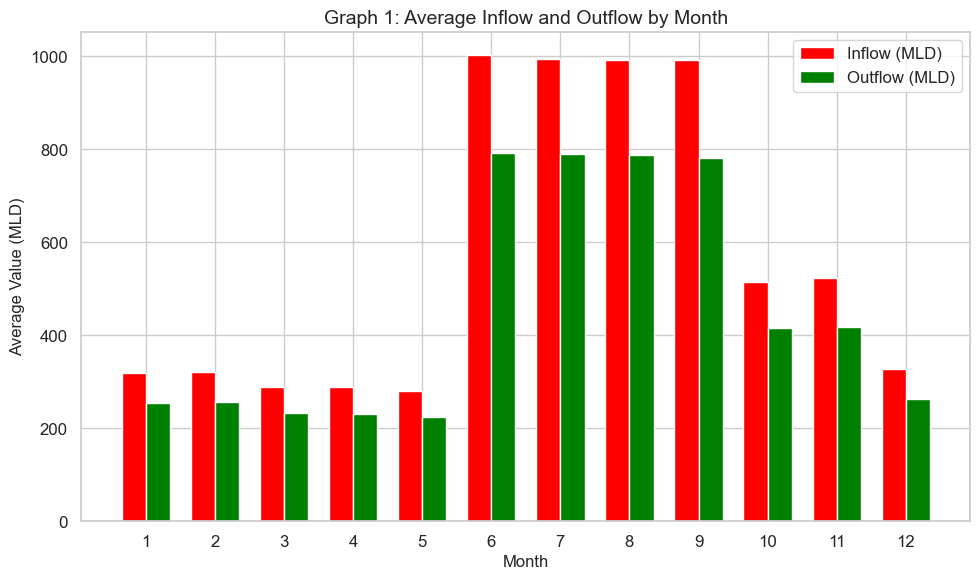

District column not found (likely one-hot encoded). Skipping Population Over Years plot.


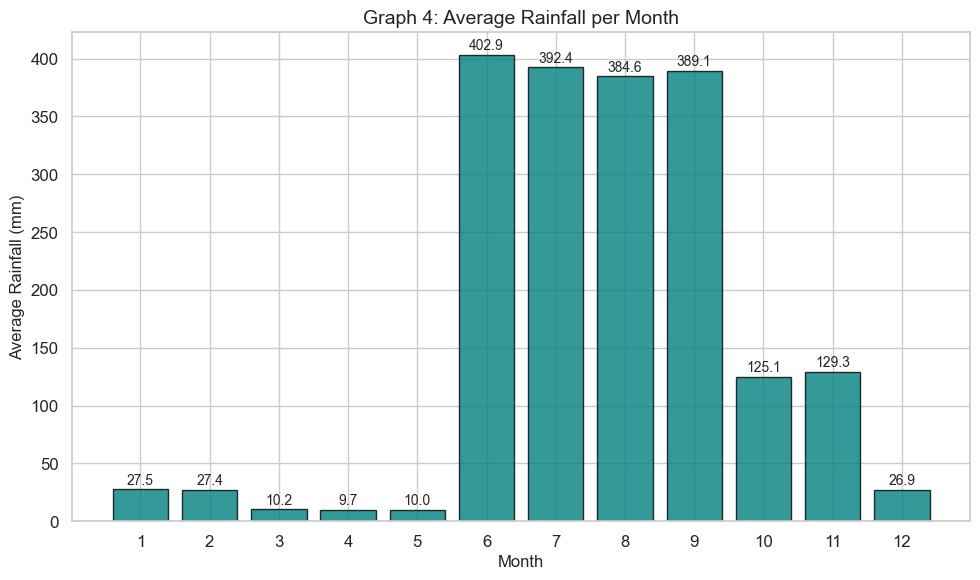

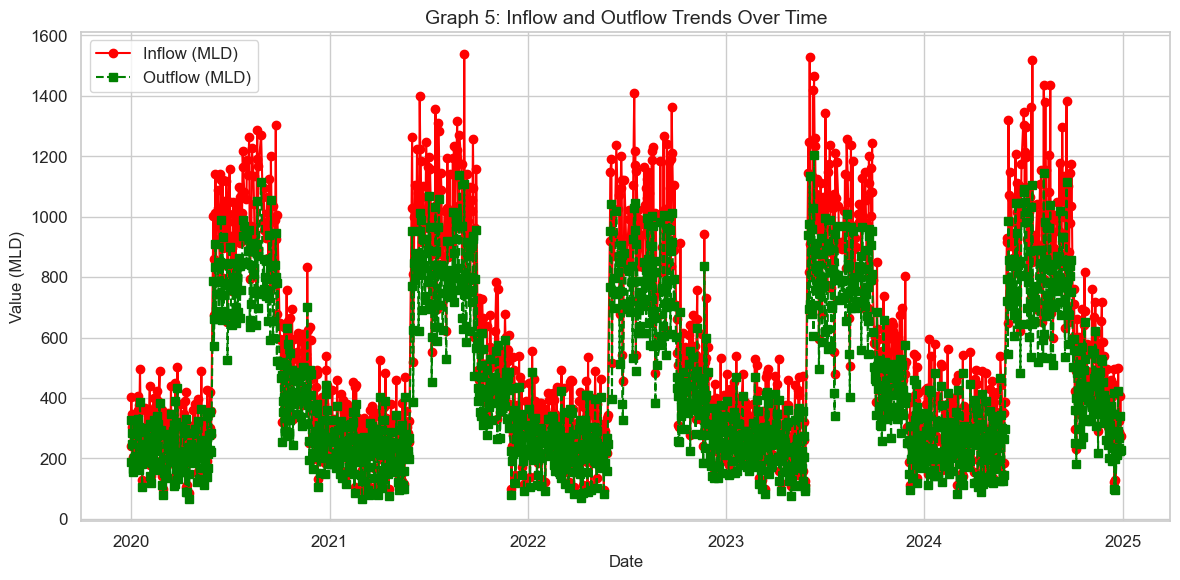

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style for plots
sns.set(style="whitegrid", font_scale=1.1)

# -------------------------------
# 1. Load the Dataset and Prepare Data

# Convert Date column to datetime (expected DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# For monthly graphs, extract month and year from Date
df['Month'] = df['Date'].dt.month
df['Year']  = df['Date'].dt.year

# --------------------------------------------------
# Graph 1: Average Inflow and Outflow by Month (Grouped Bar Chart)
# --------------------------------------------------
# Group by month and compute mean Inflow and Outflow
grouped_month = df.groupby("Month").agg({"Inflow (MLD)": "mean", "Outflow (MLD)": "mean"}).reset_index()

# Set positions and width for grouped bars
x = np.arange(len(grouped_month))  
width = 0.35  

plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width/2, grouped_month["Inflow (MLD)"], width, color='red', label="Inflow (MLD)")
bar2 = plt.bar(x + width/2, grouped_month["Outflow (MLD)"], width, color='green', label="Outflow (MLD)")

plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Value (MLD)", fontsize=12)
plt.title("Graph 1: Average Inflow and Outflow by Month", fontsize=14)
plt.xticks(x, grouped_month["Month"])
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------------------------------
# --------------------------------------------------
# Graph 3: Population Growth Over Years for Pune (Line Chart)
# --------------------------------------------------
# Ensure that the original categorical "District" column is present.
if 'District' in df.columns:
    # Filter for district 'Pune'
    df_pune = df[df['District'] == 'Pune'].copy()
    # Group by Year to get average population (or first value, as population is consistent per year)
    population_trend = df_pune.groupby("Year")["Population"].mean().reset_index()
    
    plt.figure(figsize=(10, 6))
    plt.plot(population_trend["Year"], population_trend["Population"], 
             marker='o', linestyle='-', color='blue', linewidth=2.5, label="Population")
    plt.xlabel("Year", fontsize=12, color='blue')
    plt.ylabel("Population", fontsize=12, color='green')
    plt.title("Graph 3: Population Growth Over Years in Pune", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("District column not found (likely one-hot encoded). Skipping Population Over Years plot.")

# --------------------------------------------------
# Graph 4: Average Rainfall per Month (Bar Chart)
# --------------------------------------------------
grouped_rainfall = df.groupby("Month")["Rainfall (mm)"].mean().reset_index()

plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_rainfall["Month"].astype(str), grouped_rainfall["Rainfall (mm)"], 
               color='teal', edgecolor='black', alpha=0.8)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Rainfall (mm)", fontsize=12)
plt.title("Graph 4: Average Rainfall per Month", fontsize=14)

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2, f'{height:.1f}', 
             ha='center', va='bottom', fontsize=10)
    
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Graph 5: Inflow and Outflow Trends Over Time (Line Plot with Markers)
# --------------------------------------------------
# For a trend over time, we can aggregate by Date
time_series = df.groupby("Date").agg({"Inflow (MLD)": "mean", "Outflow (MLD)": "mean"}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(time_series["Date"], time_series["Inflow (MLD)"], marker='o', linestyle='-', color='red', label="Inflow (MLD)")
plt.plot(time_series["Date"], time_series["Outflow (MLD)"], marker='s', linestyle='--', color='green', label="Outflow (MLD)")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (MLD)", fontsize=12)
plt.title("Graph 5: Inflow and Outflow Trends Over Time", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

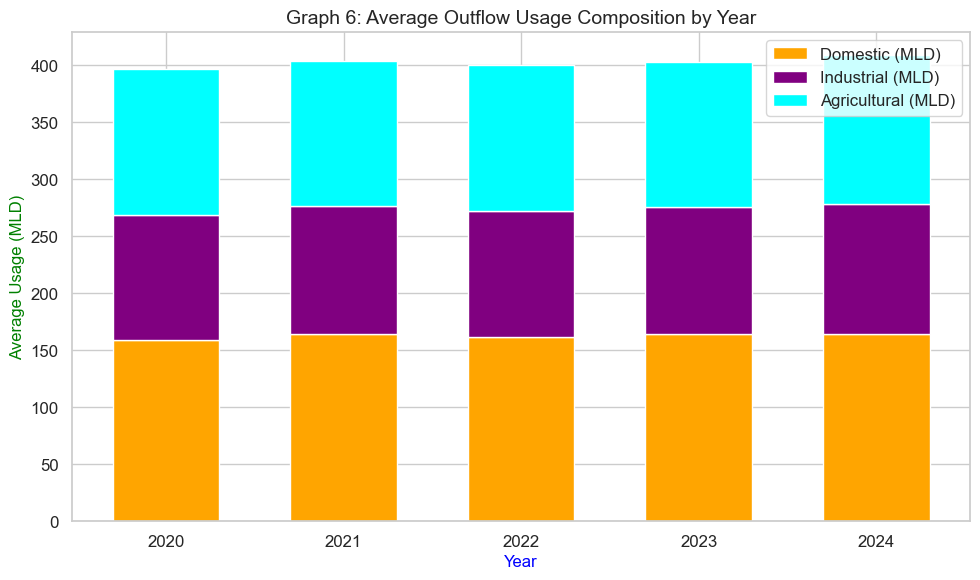

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# (Assuming previous imports and data loading have been done)
# -------------------------------
# Additional Graphs from the Dataset
# -------------------------------

# -------------------------------
# Graph 6: Average Outflow Usage Composition by Year (Stacked Bar Chart)
# -------------------------------
# Group the data by Year and compute the average values for the usage components
usage_by_year = df.groupby("Year").agg({
    "Domestic (MLD)": "mean", 
    "Industrial (MLD)": "mean", 
    "Agricultural (MLD)": "mean"
}).reset_index()

plt.figure(figsize=(10, 6))
bar_width = 0.6

# Plot Domestic usage in orange
plt.bar(usage_by_year['Year'], usage_by_year['Domestic (MLD)'], width=bar_width, 
        color='orange', label='Domestic (MLD)')

# Plot Industrial usage in purple, stacked on top of Domestic
plt.bar(usage_by_year['Year'], usage_by_year['Industrial (MLD)'], width=bar_width, 
        bottom=usage_by_year['Domestic (MLD)'], color='purple', label='Industrial (MLD)')

# Plot Agricultural usage in cyan, stacked on top of the previous two
plt.bar(usage_by_year['Year'], usage_by_year['Agricultural (MLD)'], width=bar_width, 
        bottom=usage_by_year['Domestic (MLD)'] + usage_by_year['Industrial (MLD)'], 
        color='cyan', label='Agricultural (MLD)')

plt.xlabel("Year", fontsize=12, color='blue')
plt.ylabel("Average Usage (MLD)", fontsize=12, color='green')
plt.title("Graph 6: Average Outflow Usage Composition by Year", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()